In [27]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr

Selected exercises.

>1. This exercise is about regularization priors. In the code that generates the x_c, y_c
data (see https://github.com/aloctavodia/BAP3), change order=2 to another
value, such as order=5. Then, fit model_q and plot the resulting curve. Repeat this,
but now using a prior for 𝛽 with sd=100 instead of sd=1 and plot the resulting curve.
How do the curves differ? Try this out with sd=np.array([10, 0.1, 0.1, 0.1,
0.1]), too.

>2. Repeat the previous exercise but increase the amount of data to 500 data points. (Skipping, because the data is pregenerated, so how??)

>5. Read and run the posterior predictive example from PyMC’s documentation at
https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pos
terior_predictive.html. Pay special attention to the use of shared variables and
pm.MutableData.

##  Exercise 1

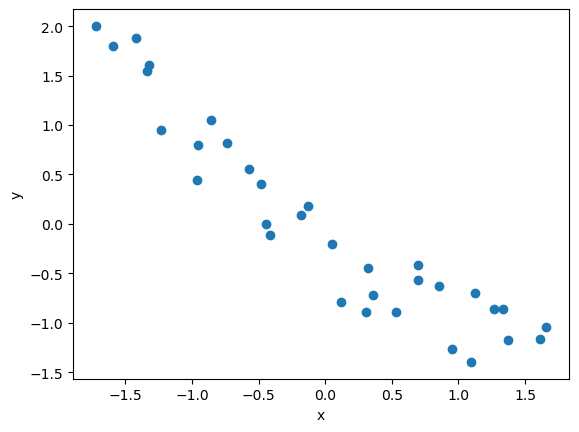

In [6]:
dummy_data = np.loadtxt("../code/data/dummy.csv")
x = dummy_data[:, 0]
y = dummy_data[:, 1]

order = 5
x_p = np.vstack([x**i for i in range(1, order + 1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
plt.scatter(x_c[0], y_c)
plt.xlabel("x")
plt.ylabel("y");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_pred]


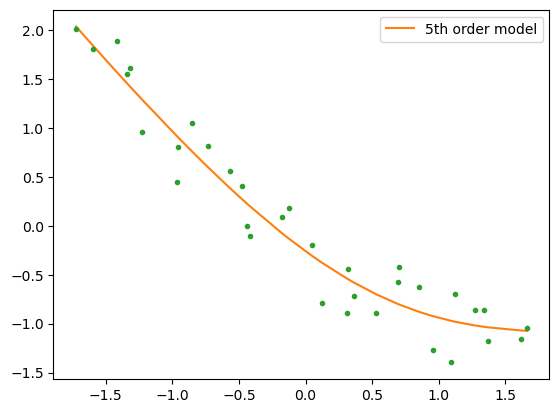

In [13]:
with pm.Model() as model_q:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=1, shape=order)
    σ = pm.HalfNormal("σ", 5)

    μ = α + pm.math.dot(β, x_c)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    idata_q.extend(pm.sample_posterior_predictive(idata_q, random_seed=4591))

x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

 
posterior_p = az.extract(idata_q)

 

α_p_post = posterior_p["α"].mean().item()
β_p_post = posterior_p["β"].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = α_p_post + np.dot(β_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], "C1", label=f"5th order model")

plt.plot(x_c[0], y_c, "C2.")
plt.legend()
 

In [14]:
az.summary(idata_q, var_names=["α", "β", "σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.000,0.049,-0.091,0.093,0.001,0.001,6009.0,4884.0,1.0
β[0],-1.403,0.146,-1.679,-1.128,0.002,0.001,6085.0,5421.0,1.0
β[1],0.284,0.423,-0.487,1.117,0.007,0.005,4200.0,4859.0,1.0
β[2],0.237,0.721,-1.194,1.536,0.011,0.008,4306.0,4699.0,1.0
β[3],0.155,0.816,-1.372,1.670,0.014,0.010,3439.0,4330.0,1.0
β[4],-0.160,0.544,-1.117,0.918,0.009,0.007,3589.0,4207.0,1.0
σ,0.278,0.039,0.212,0.351,0.001,0.000,5697.0,4796.0,1.0


Now with wide prior on  $\beta$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.
Sampling: [y_pred]


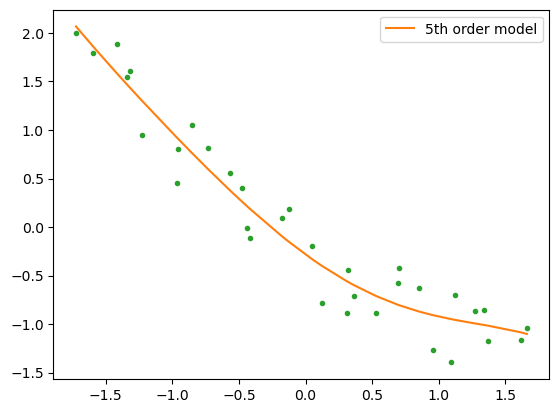

In [18]:
with pm.Model() as model_q:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=100, shape=order)
    σ = pm.HalfNormal("σ", 5)

    μ = α + pm.math.dot(β, x_c)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True}, target_accept = 0.9, random_seed=4591)
    idata_q.extend(pm.sample_posterior_predictive(idata_q, random_seed=4591))

x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

 
posterior_p = az.extract(idata_q)

 

α_p_post = posterior_p["α"].mean().item()
β_p_post = posterior_p["β"].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = α_p_post + np.dot(β_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], "C1", label=f"5th order model")

plt.plot(x_c[0], y_c, "C2.")
plt.legend()

In [19]:
az.summary(idata_q, var_names=["α", "β", "σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.002,0.050,-0.099,0.090,0.001,0.001,3973.0,3650.0,1.0
β[0],-1.427,0.284,-1.982,-0.917,0.006,0.004,2469.0,3481.0,1.0
β[1],0.246,0.657,-1.057,1.415,0.009,0.008,5092.0,4286.0,1.0
β[2],0.158,3.096,-6.010,5.631,0.065,0.046,2300.0,2905.0,1.0
β[3],0.641,5.339,-10.043,10.119,0.116,0.082,2118.0,2651.0,1.0
β[4],-0.512,2.715,-5.324,4.893,0.058,0.041,2193.0,3060.0,1.0
σ,0.288,0.042,0.220,0.370,0.001,0.000,3983.0,4504.0,1.0


tends to fit it a bit more sharply, but whatever. Errors are big on the parameteres.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_pred]


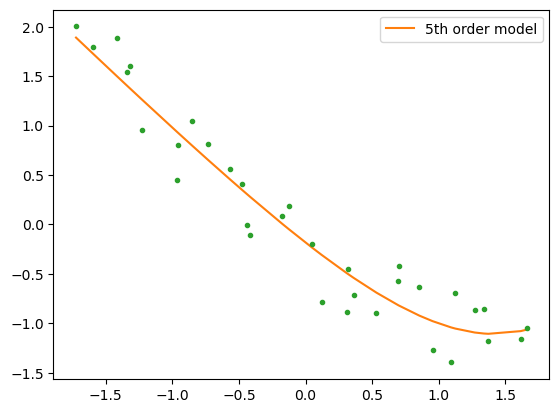

In [20]:
with pm.Model() as model_q:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=np.array([10, 0.1, 0.1, 0.1,
0.1]), shape=order)
    σ = pm.HalfNormal("σ", 5)

    μ = α + pm.math.dot(β, x_c)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    idata_q.extend(pm.sample_posterior_predictive(idata_q, random_seed=4591))

x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

 
posterior_p = az.extract(idata_q)

 

α_p_post = posterior_p["α"].mean().item()
β_p_post = posterior_p["β"].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = α_p_post + np.dot(β_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], "C1", label=f"5th order model")

plt.plot(x_c[0], y_c, "C2.")
plt.legend()

In [21]:
az.summary(idata_q, var_names=["α", "β", "σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.000,0.049,-0.089,0.099,0.001,0.001,8098.0,5220.0,1.0
β[0],-1.233,0.094,-1.411,-1.060,0.001,0.001,6670.0,5762.0,1.0
β[1],0.098,0.092,-0.077,0.266,0.001,0.001,7106.0,5251.0,1.0
β[2],0.092,0.092,-0.076,0.267,0.001,0.001,7778.0,5287.0,1.0
β[3],0.087,0.088,-0.079,0.248,0.001,0.001,7859.0,5724.0,1.0
β[4],0.073,0.082,-0.083,0.223,0.001,0.001,8189.0,5802.0,1.0
σ,0.284,0.039,0.217,0.359,0.000,0.000,6481.0,4274.0,1.0


This kept the other parameters small (and are basically same as prior). Except beta 0.

## Exercise 5

In [22]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

Simulate simple linear data

In [23]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'1.59, 5.69, 4.97, 17.54'

Rescale the data

In [24]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'-0.00, 1.00, -0.00, 1.00'

Fit with flatish priors

In [25]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


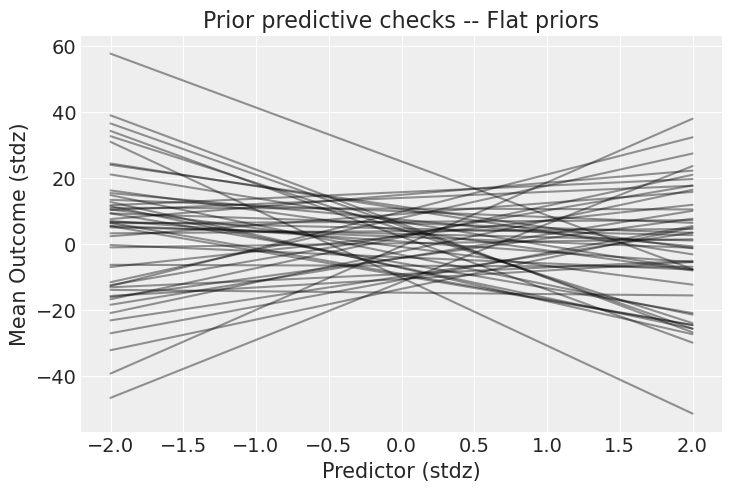

In [29]:
_, ax = plt.subplots()

# Use xarray to take advantage of broadcasting
x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

This is way to permissive, this is standardized data after all !  Lets be more restrictive with weakly informative priors

Sampling: [a, b, obs, sigma]


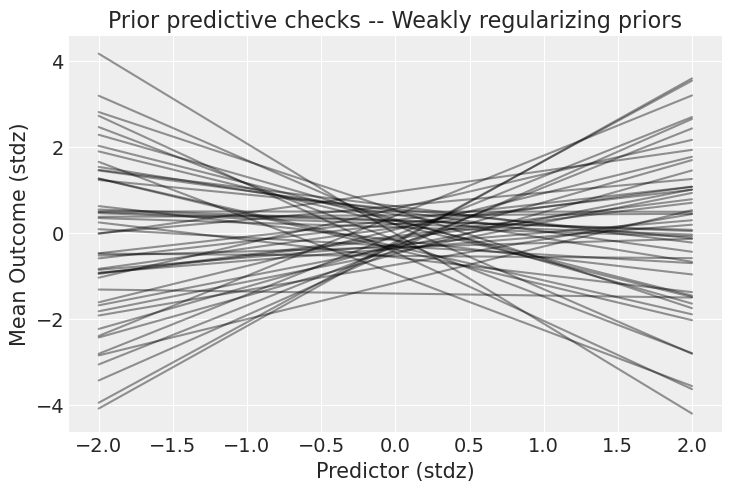

In [37]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = pm.Deterministic("mu",a + b * predictor_scaled)
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

Much better

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


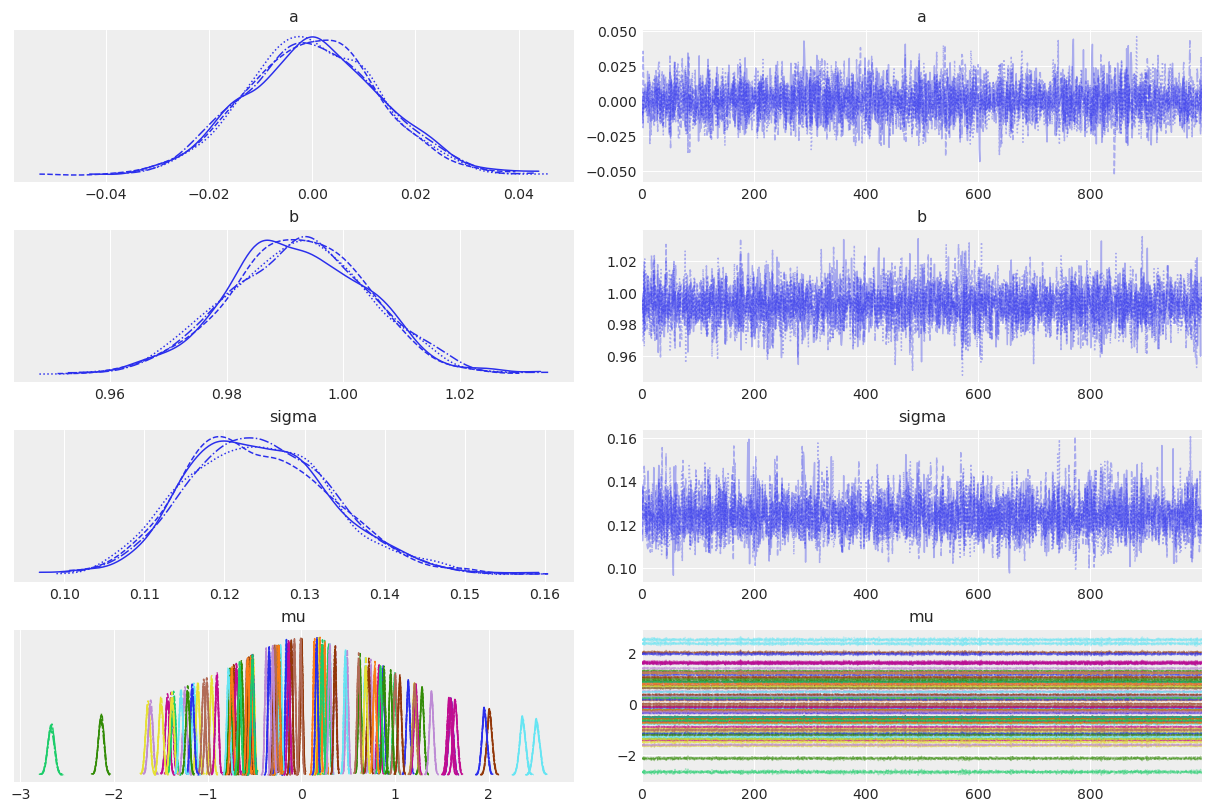

In [38]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

Lets look at the posterior predictive.

In [40]:
with model_1:
    pm.sample_posterior_predictive(idata,var_names=["mu","obs"], extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


In [41]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

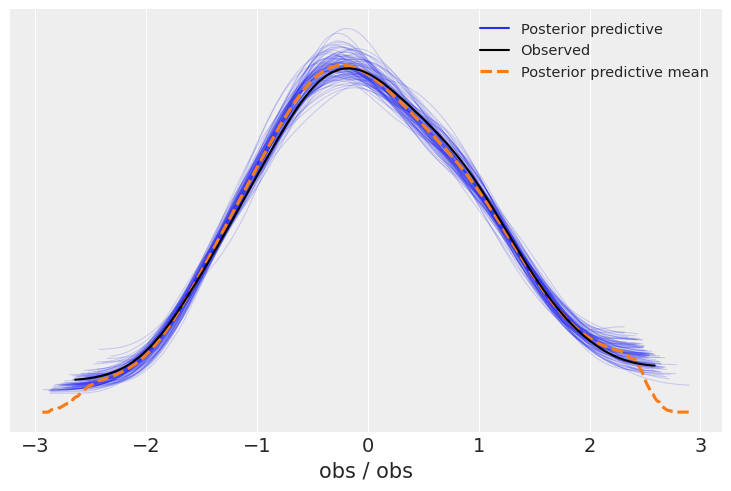

In [42]:
az.plot_ppc(idata, num_pp_samples=100);

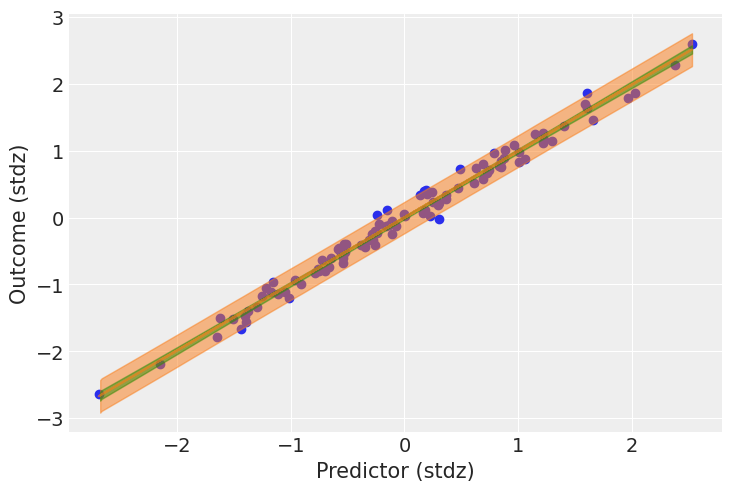

In [44]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims=["obs_id"])

_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["mu"], color="C2")

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

### Prediction
Using a logistic regression

In [46]:
from scipy.special import expit as logistic

N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [47]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.34,0.11,0.14,0.54,0.0,0.0,3346.51,2404.14,1.0
betas[1],1.11,0.14,0.86,1.37,0.0,0.0,3766.29,3105.27,1.0


Now lets do out of sample predictions

In [48]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: []


In [50]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

We can look at our uncertainty in predictions 

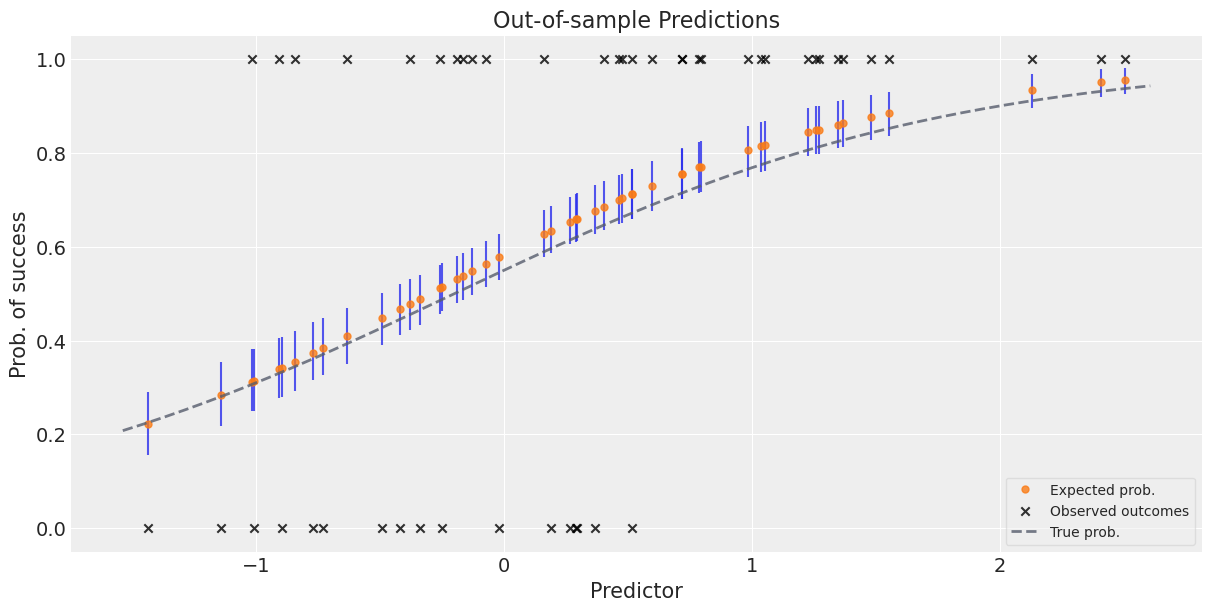

In [51]:
_, ax = plt.subplots(figsize=(12, 6))

# pred is "predictor" not prediction 

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);